<img src="http://hauteliving.com/wp-content/uploads/2012/03/lc.jpg">

### This jupyter notebook aims to build a baseline model for restaurant visitor count forecast problem using Linear Regression.
##### In this, the following features are included;
###### air_store_id    => restaurant id in Air system
###### air_genre_name => categorical variable which defines the cuisine being served by the restaurant
###### latitude + longitude => instead of taking two separate variables for geographic location, adding both columns to yield a single one..
###### visitors => number of Visitors visited the restaurant without any reservation (This is Dependent variable to predict )
###### time_diff=> this column adds the difference of time between reservation and visiting date
###### holiday_flg => this column defines whether the given calendar date is holiday or not
###### Week_day => defines whether the date comes on Monday/Tuesday.../Sunday...so on
###### day => date of the day
###### month => represents month
###### year => represents year from calendar date
###### fri => column to represent whether the date is friday
###### sat => column to represent whether the date is saturday
###### sun => column to represent whether the date is sunday

#### The RMSE (Root mean squared error ) value measured is 0.715

In [217]:
#Load all the data to dataFrames
%matplotlib inline
import pandas as pd
import numpy as np
import re
import warnings
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
import seaborn as sns
plt.style.use('ggplot')
warnings.simplefilter("ignore")
#Create  dataframes
df_total_visit_reserve = pd.read_csv(".//Total_reserve_visit_data.csv")
df_store_id_realation = pd.read_csv('.//store_id_relation.csv')
df_test_set = pd.read_csv('.//sample_submission.csv')
df_air_store_info = pd.read_csv('.//air_store_info.csv')
df_hpg_store_info = pd.read_csv('.//hpg_store_info.csv')
df_date_info = pd.read_csv('.//date_info.csv')
df_total_hpg_store_info = pd.merge(df_hpg_store_info,df_store_id_realation,how='inner',on='hpg_store_id')
df_total_hpg_store_info = df_total_hpg_store_info.drop('hpg_store_id',axis=1)
df_total_hpg_store_info = df_total_hpg_store_info.rename(columns={'hpg_genre_name':'air_genre_name','hpg_area_name':'air_area_name'})
df_air_hpg_total_store_info = df_air_store_info.append(df_total_hpg_store_info)

In [218]:
df_air_hpg_total_store_info.head()

,air_area_name,air_genre_name,air_store_id,latitude,longitude
0,Hyōgo-ken Kōbe-shi Kumoidōri,Italian/French,air_0f0cdeee6c9bf3d7,34.695124,135.197852
1,Hyōgo-ken Kōbe-shi Kumoidōri,Italian/French,air_7cc17a324ae5c7dc,34.695124,135.197852
2,Hyōgo-ken Kōbe-shi Kumoidōri,Italian/French,air_fee8dcf4d619598e,34.695124,135.197852
3,Hyōgo-ken Kōbe-shi Kumoidōri,Italian/French,air_a17f0778617c76e2,34.695124,135.197852
4,Tōkyō-to Minato-ku Shibakōen,Italian/French,air_83db5aff8f50478e,35.658068,139.751599


In [219]:
df_air_hpg_total_store_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892 entries, 0 to 62
Data columns (total 5 columns):
air_area_name     892 non-null object
air_genre_name    892 non-null object
air_store_id      892 non-null object
latitude          892 non-null float64
longitude         892 non-null float64
dtypes: float64(2), object(3)
memory usage: 41.8+ KB


In [220]:
df_total_visit_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291792 entries, 0 to 291791
Data columns (total 5 columns):
air_store_id        291792 non-null object
reserve_visitors    291792 non-null int64
time_diff           291792 non-null int64
visit_date          291792 non-null object
visitors            291792 non-null int64
dtypes: int64(3), object(2)
memory usage: 11.1+ MB


In [221]:
len(df_total_visit_reserve.air_store_id.unique())

829

In [222]:
len(df_air_hpg_total_store_info.air_store_id.unique())

829

In [223]:
df_total_visit_reserve.head()

,air_store_id,reserve_visitors,time_diff,visit_date,visitors
0,air_00a91d42b08b08d9,2,3,1/14/2016,0
1,air_00a91d42b08b08d9,4,6,1/15/2016,0
2,air_00a91d42b08b08d9,2,3,1/16/2016,0
3,air_00a91d42b08b08d9,2,3,1/22/2016,0
4,air_00a91d42b08b08d9,5,6,1/29/2016,0


In [224]:
df_air_hpg_total_store_info.head()

,air_area_name,air_genre_name,air_store_id,latitude,longitude
0,Hyōgo-ken Kōbe-shi Kumoidōri,Italian/French,air_0f0cdeee6c9bf3d7,34.695124,135.197852
1,Hyōgo-ken Kōbe-shi Kumoidōri,Italian/French,air_7cc17a324ae5c7dc,34.695124,135.197852
2,Hyōgo-ken Kōbe-shi Kumoidōri,Italian/French,air_fee8dcf4d619598e,34.695124,135.197852
3,Hyōgo-ken Kōbe-shi Kumoidōri,Italian/French,air_a17f0778617c76e2,34.695124,135.197852
4,Tōkyō-to Minato-ku Shibakōen,Italian/French,air_83db5aff8f50478e,35.658068,139.751599


In [225]:
df_total = pd.merge(df_total_visit_reserve,df_air_hpg_total_store_info,how='inner',on='air_store_id')
df_total['visit_date'] = pd.to_datetime(df_total['visit_date'])
df_date_info.calendar_date = pd.to_datetime(df_date_info.calendar_date)
#change the index of df_date_info to calendar_date
df_date_info = df_date_info.set_index('calendar_date')
df_total['holiday_flg'] = df_total.visit_date.apply(lambda x : df_date_info.loc[x]['holiday_flg'])
df_total.head(10)

,air_store_id,reserve_visitors,time_diff,visit_date,visitors,air_area_name,air_genre_name,latitude,longitude,holiday_flg
0,air_00a91d42b08b08d9,2,3,2016-01-14,0,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
1,air_00a91d42b08b08d9,4,6,2016-01-15,0,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
2,air_00a91d42b08b08d9,2,3,2016-01-16,0,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
3,air_00a91d42b08b08d9,2,3,2016-01-22,0,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
4,air_00a91d42b08b08d9,5,6,2016-01-29,0,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
5,air_00a91d42b08b08d9,2,16,2016-02-05,0,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
6,air_00a91d42b08b08d9,3,2,2016-03-08,0,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
7,air_00a91d42b08b08d9,1,4,2016-04-04,0,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
8,air_00a91d42b08b08d9,2,1,2016-04-07,0,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
9,air_00a91d42b08b08d9,7,13,2016-04-08,0,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0


In [226]:
df_total.tail()

,air_store_id,reserve_visitors,time_diff,visit_date,visitors,air_area_name,air_genre_name,latitude,longitude,holiday_flg
322332,air_fff68b929994bfbd,5,16,2017-04-18,6,Tōkyō-to Nakano-ku Nakano,Bar/Cocktail,35.708146,139.666288,0
322333,air_fff68b929994bfbd,5,16,2017-04-19,2,Tōkyō-to Nakano-ku Nakano,Bar/Cocktail,35.708146,139.666288,0
322334,air_fff68b929994bfbd,5,16,2017-04-20,2,Tōkyō-to Nakano-ku Nakano,Bar/Cocktail,35.708146,139.666288,0
322335,air_fff68b929994bfbd,5,16,2017-04-21,4,Tōkyō-to Nakano-ku Nakano,Bar/Cocktail,35.708146,139.666288,0
322336,air_fff68b929994bfbd,5,16,2017-04-22,5,Tōkyō-to Nakano-ku Nakano,Bar/Cocktail,35.708146,139.666288,0


In [227]:
# have a single column of visitors instead of two
df_total['visitors'] = df_total['visitors'] + df_total['reserve_visitors']

In [228]:
df_total = df_total.drop('reserve_visitors',axis=1)

##### Change the columns to their respective types
#####   air_area_name =====> categorical type
#####   air_genre_name ===> categorical type 

In [229]:
#Change latitude,longitude type to float type
df_total['latitude'] = df_total['latitude'].convert_objects(convert_numeric=True)
df_total['longitude'] = df_total['longitude'].convert_objects(convert_numeric=True)

#change the air_genre_name,air_store_id to categorical type
df_total['air_area_name'] = df_total['air_area_name'].astype('category')
df_total['air_genre_name'] = df_total['air_genre_name'].astype('category')

In [230]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322337 entries, 0 to 322336
Data columns (total 9 columns):
air_store_id      322337 non-null object
time_diff         322337 non-null int64
visit_date        322337 non-null datetime64[ns]
visitors          322337 non-null int64
air_area_name     322337 non-null category
air_genre_name    322337 non-null category
latitude          322337 non-null float64
longitude         322337 non-null float64
holiday_flg       322337 non-null int64
dtypes: category(2), datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 20.6+ MB


In [231]:
df_total.head()

,air_store_id,time_diff,visit_date,visitors,air_area_name,air_genre_name,latitude,longitude,holiday_flg
0,air_00a91d42b08b08d9,3,2016-01-14,2,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
1,air_00a91d42b08b08d9,6,2016-01-15,4,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
2,air_00a91d42b08b08d9,3,2016-01-16,2,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
3,air_00a91d42b08b08d9,3,2016-01-22,2,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
4,air_00a91d42b08b08d9,6,2016-01-29,5,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0


In [232]:
#Add new features fri/Sat/Sun
#fri == 4; sat == 5; sun == 6
df_total['Week_day'] = df_total['visit_date'].dt.dayofweek
df_total['day'] = df_total['visit_date'].dt.day
df_total['month'] = df_total['visit_date'].dt.month
df_total['year'] = df_total['visit_date'].dt.year
df_total['fri'] = (df_total['Week_day'] == 4)*1
df_total['sat'] = (df_total['Week_day'] == 5)*1
df_total['sun'] = (df_total['Week_day'] == 6)*1
df_total['geo_location'] = (df_total['latitude'] + df_total['longitude'])
df_total = df_total.drop(['visit_date'],axis=1)
df_total.head(10)

,air_store_id,time_diff,visitors,air_area_name,air_genre_name,latitude,longitude,holiday_flg,Week_day,day,month,year,fri,sat,sun,geo_location
0,air_00a91d42b08b08d9,3,2,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,3,14,1,2016,0,0,0,175.447598
1,air_00a91d42b08b08d9,6,4,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,4,15,1,2016,1,0,0,175.447598
2,air_00a91d42b08b08d9,3,2,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,5,16,1,2016,0,1,0,175.447598
3,air_00a91d42b08b08d9,3,2,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,4,22,1,2016,1,0,0,175.447598
4,air_00a91d42b08b08d9,6,5,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,4,29,1,2016,1,0,0,175.447598
5,air_00a91d42b08b08d9,16,2,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,4,5,2,2016,1,0,0,175.447598
6,air_00a91d42b08b08d9,2,3,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,1,8,3,2016,0,0,0,175.447598
7,air_00a91d42b08b08d9,4,1,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,0,4,4,2016,0,0,0,175.447598
8,air_00a91d42b08b08d9,1,2,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,3,7,4,2016,0,0,0,175.447598
9,air_00a91d42b08b08d9,13,7,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,4,8,4,2016,1,0,0,175.447598


In [233]:
df_total.tail(10)

,air_store_id,time_diff,visitors,air_area_name,air_genre_name,latitude,longitude,holiday_flg,Week_day,day,month,year,fri,sat,sun,geo_location
322327,air_fff68b929994bfbd,16,6,Tōkyō-to Nakano-ku Nakano,Bar/Cocktail,35.708146,139.666288,0,3,13,4,2017,0,0,0,175.374434
322328,air_fff68b929994bfbd,16,10,Tōkyō-to Nakano-ku Nakano,Bar/Cocktail,35.708146,139.666288,0,4,14,4,2017,1,0,0,175.374434
322329,air_fff68b929994bfbd,16,12,Tōkyō-to Nakano-ku Nakano,Bar/Cocktail,35.708146,139.666288,0,5,15,4,2017,0,1,0,175.374434
322330,air_fff68b929994bfbd,16,12,Tōkyō-to Nakano-ku Nakano,Bar/Cocktail,35.708146,139.666288,0,6,16,4,2017,0,0,1,175.374434
322331,air_fff68b929994bfbd,16,8,Tōkyō-to Nakano-ku Nakano,Bar/Cocktail,35.708146,139.666288,0,0,17,4,2017,0,0,0,175.374434
322332,air_fff68b929994bfbd,16,11,Tōkyō-to Nakano-ku Nakano,Bar/Cocktail,35.708146,139.666288,0,1,18,4,2017,0,0,0,175.374434
322333,air_fff68b929994bfbd,16,7,Tōkyō-to Nakano-ku Nakano,Bar/Cocktail,35.708146,139.666288,0,2,19,4,2017,0,0,0,175.374434
322334,air_fff68b929994bfbd,16,7,Tōkyō-to Nakano-ku Nakano,Bar/Cocktail,35.708146,139.666288,0,3,20,4,2017,0,0,0,175.374434
322335,air_fff68b929994bfbd,16,9,Tōkyō-to Nakano-ku Nakano,Bar/Cocktail,35.708146,139.666288,0,4,21,4,2017,1,0,0,175.374434
322336,air_fff68b929994bfbd,16,10,Tōkyō-to Nakano-ku Nakano,Bar/Cocktail,35.708146,139.666288,0,5,22,4,2017,0,1,0,175.374434


In [234]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_total['air_store_id'].values)

LabelEncoder()

In [235]:
df_total['air_store_id'] = le.transform(df_total['air_store_id'].values)

In [236]:
df_total.head()

,air_store_id,time_diff,visitors,air_area_name,air_genre_name,latitude,longitude,holiday_flg,Week_day,day,month,year,fri,sat,sun,geo_location
0,0,3,2,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,3,14,1,2016,0,0,0,175.447598
1,0,6,4,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,4,15,1,2016,1,0,0,175.447598
2,0,3,2,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,5,16,1,2016,0,1,0,175.447598
3,0,3,2,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,4,22,1,2016,1,0,0,175.447598
4,0,6,5,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,4,29,1,2016,1,0,0,175.447598


In [237]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322337 entries, 0 to 322336
Data columns (total 16 columns):
air_store_id      322337 non-null int64
time_diff         322337 non-null int64
visitors          322337 non-null int64
air_area_name     322337 non-null category
air_genre_name    322337 non-null category
latitude          322337 non-null float64
longitude         322337 non-null float64
holiday_flg       322337 non-null int64
Week_day          322337 non-null int64
day               322337 non-null int64
month             322337 non-null int64
year              322337 non-null int64
fri               322337 non-null int32
sat               322337 non-null int32
sun               322337 non-null int32
geo_location      322337 non-null float64
dtypes: category(2), float64(3), int32(3), int64(8)
memory usage: 34.1 MB


In [238]:
df_total.describe()

,air_store_id,time_diff,visitors,latitude,longitude,holiday_flg,Week_day,day,month,year,fri,sat,sun,geo_location
count,322337.000000,322337.000000,322337.000000,322337.000000,322337.000000,322337.000000,322337.000000,322337.000000,322337.000000,322337.000000,322337.000000,322337.000000,322337.000000,322337.000000
mean,411.553778,17.759478,27.772831,35.744047,137.285636,0.051964,3.048998,15.659598,6.104772,2016.318272,0.165299,0.161564,0.117793,173.029684
std,241.733996,230.362512,24.616670,2.292232,3.719765,0.221955,1.918633,8.672211,3.711840,0.465807,0.371451,0.368051,0.322363,5.497641
min,0.000000,0.000000,1.000000,33.211967,130.195555,0.000000,0.000000,1.000000,1.000000,2016.000000,0.000000,0.000000,0.000000,163.752875
25%,199.000000,16.000000,13.000000,34.681261,135.197852,0.000000,1.000000,8.000000,3.000000,2016.000000,0.000000,0.000000,0.000000,169.892977
50%,400.000000,16.000000,22.000000,35.658068,139.653247,0.000000,3.000000,16.000000,6.000000,2016.000000,0.000000,0.000000,0.000000,175.339634
75%,626.000000,16.000000,36.000000,35.694003,139.751599,0.000000,5.000000,23.000000,10.000000,2017.000000,0.000000,0.000000,0.000000,175.442512
max,828.000000,67329.000000,2834.000000,44.020632,144.273398,1.000000,6.000000,31.000000,12.000000,2017.000000,1.000000,1.000000,1.000000,188.294030


#### First lets check the correlations between features through scatter plot

#### Relation between time_diff and Visitors

In [239]:
df_total['time_diff'].max()

67329

(0, 67329)

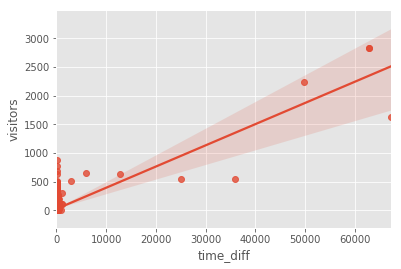

In [240]:
sns.regplot(y="visitors", x="time_diff", data=df_total, fit_reg = True)
plt.xlim((0,(df_total['time_diff'].max())))

##### From the plot it is informative that, most of the visitors are visiting without reservations

##### Holiday effect on visitors

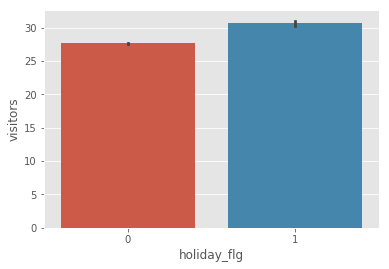

In [241]:
sns.barplot(y="visitors", x="holiday_flg", data=df_total)

#### Visitors and geo_location relation

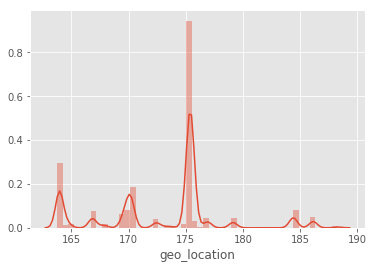

In [242]:
sns.distplot(df_total["geo_location"])
#plt.xlim((0,(df_total['time_diff'].max())))

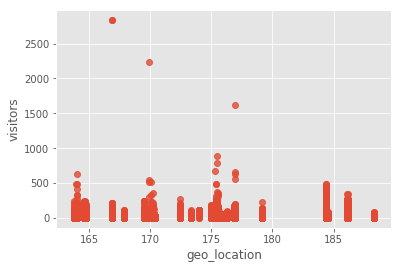

In [243]:
sns.regplot(data=df_total, x='geo_location', y='visitors',fit_reg=False)

#### There are more number of visitors in golidays

In [391]:
df_with_dummies = pd.get_dummies(df_total.drop(['latitude','longitude'],axis=1))
df_with_dummies.head()

,air_store_id,time_diff,visitors,holiday_flg,Week_day,day,month,year,fri,sat,...,air_genre_name_Karaoke,air_genre_name_Karaoke/Party,air_genre_name_Okonomiyaki/Monja/Teppanyaki,air_genre_name_Other,air_genre_name_Party,air_genre_name_Seafood,air_genre_name_Spain Bar/Italian Bar,air_genre_name_Steak/Hamburger/Curry,air_genre_name_Western food,air_genre_name_Yakiniku/Korean food
0,0,3,2,0,3,14,1,2016,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,6,4,0,4,15,1,2016,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,3,2,0,5,16,1,2016,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,3,2,0,4,22,1,2016,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,6,5,0,4,29,1,2016,1,0,...,0,0,0,0,0,0,0,0,0,0


In [392]:
df_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322337 entries, 0 to 322336
Columns: 173 entries, air_store_id to air_genre_name_Yakiniku/Korean food
dtypes: float64(1), int32(3), int64(8), uint8(161)
memory usage: 87.8 MB


In [405]:
y = np.log1p(df_with_dummies[['visitors']]).values
X = df_with_dummies.drop(['visitors'],axis=1).values

In [406]:
X

array([[   0.,    3.,    0., ...,    0.,    0.,    0.],
       [   0.,    6.,    0., ...,    0.,    0.,    0.],
       [   0.,    3.,    0., ...,    0.,    0.,    0.],
       ..., 
       [ 828.,   16.,    0., ...,    0.,    0.,    0.],
       [ 828.,   16.,    0., ...,    0.,    0.,    0.],
       [ 828.,   16.,    0., ...,    0.,    0.,    0.]])

In [407]:
X

array([[   0.,    3.,    0., ...,    0.,    0.,    0.],
       [   0.,    6.,    0., ...,    0.,    0.,    0.],
       [   0.,    3.,    0., ...,    0.,    0.,    0.],
       ..., 
       [ 828.,   16.,    0., ...,    0.,    0.,    0.],
       [ 828.,   16.,    0., ...,    0.,    0.,    0.],
       [ 828.,   16.,    0., ...,    0.,    0.,    0.]])

In [408]:
y

array([[ 1.09861229],
       [ 1.60943791],
       [ 1.09861229],
       ..., 
       [ 2.07944154],
       [ 2.30258509],
       [ 2.39789527]])

In [409]:
X[:,0]  #air_store_ids

array([   0.,    0.,    0., ...,  828.,  828.,  828.])

In [410]:
X[:,2] #air_genre_names

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [411]:
print(X)
print(type(X))

[[   0.    3.    0. ...,    0.    0.    0.]
 [   0.    6.    0. ...,    0.    0.    0.]
 [   0.    3.    0. ...,    0.    0.    0.]
 ..., 
 [ 828.   16.    0. ...,    0.    0.    0.]
 [ 828.   16.    0. ...,    0.    0.    0.]
 [ 828.   16.    0. ...,    0.    0.    0.]]
<class 'numpy.ndarray'>


In [412]:
X.shape

(322337, 172)

In [413]:
y.shape

(322337, 1)

In [415]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.datasets.longley import load_pandas
from statsmodels.formula.api import ols
ols_model = sm.OLS(np.log1p(df_with_dummies['visitors']), df_with_dummies.drop(['visitors'],axis=1))
ols_results = ols_model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:               visitors   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     238.0
Date:                Tue, 30 Jan 2018   Prob (F-statistic):               0.00
Time:                        23:47:15   Log-Likelihood:            -3.4176e+05
No. Observations:              322337   AIC:                         6.839e+05
Df Residuals:                  322167   BIC:                         6.857e+05
Df Model:                         169                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [452]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  scale
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [453]:
y_pred = lm.predict(X_test)
from sklearn.metrics import mean_squared_error
#squared_error = ((y_pred + 1) - (y_test + 1)) ** 2
#rmsle = np.sqrt( np.sum(squared_error) / len(y_pred) )
rmse = np.sqrt(mean_squared_error(y_pred,y_test))
print("RMSE",rmse)
print(max(y_pred))
#print(y_pred)

RMSE 0.69830725588
[ 12.64050668]


In [454]:
print("Training Accuracy : ",lm.score(X_train,y_train))
print("Test Accuracy : ",lm.score(X_test,y_test))

Training Accuracy :  0.11130737982
Test Accuracy :  0.109455925191


### Predicting on Test set which spans from April 2017

In [455]:
#creating ,weekday column for df_test_set
df_test_set['air_store_id'] = df_test_set['id'].map(lambda x : "_".join(x.split('_')[:2]))
df_test_set['visit_date'] = df_test_set['id'].map(lambda x : "_".join(x.split('_')[2:]))
df_test_set['visit_date'] = pd.to_datetime(df_test_set['visit_date'])
df_test_set['Week_day'] = df_test_set['visit_date'].dt.dayofweek
df_test_set['month'] = df_test_set['visit_date'].dt.month
df_test_set['day'] = df_test_set['visit_date'].dt.day
df_test_set['year'] = df_test_set['visit_date'].dt.year
df_test_set.head()

,id,visitors,air_store_id,visit_date,Week_day,month,day,year
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23,6,4,23,2017
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24,0,4,24,2017
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25,1,4,25,2017
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26,2,4,26,2017
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27,3,4,27,2017


In [456]:
df_test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32019 entries, 0 to 32018
Data columns (total 8 columns):
id              32019 non-null object
visitors        32019 non-null int64
air_store_id    32019 non-null object
visit_date      32019 non-null datetime64[ns]
Week_day        32019 non-null int64
month           32019 non-null int64
day             32019 non-null int64
year            32019 non-null int64
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 2.0+ MB


In [457]:
df_test_total = pd.merge(df_test_set,df_air_hpg_total_store_info,how='inner',on='air_store_id')
df_test_total['holiday_flg'] = df_test_total.visit_date.apply(lambda x : df_date_info.loc[x]['holiday_flg'])
df_test_total.head(10)

,id,visitors,air_store_id,visit_date,Week_day,month,day,year,air_area_name,air_genre_name,latitude,longitude,holiday_flg
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23,6,4,23,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24,0,4,24,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25,1,4,25,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26,2,4,26,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27,3,4,27,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
5,air_00a91d42b08b08d9_2017-04-28,0,air_00a91d42b08b08d9,2017-04-28,4,4,28,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
6,air_00a91d42b08b08d9_2017-04-29,0,air_00a91d42b08b08d9,2017-04-29,5,4,29,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,1
7,air_00a91d42b08b08d9_2017-04-30,0,air_00a91d42b08b08d9,2017-04-30,6,4,30,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
8,air_00a91d42b08b08d9_2017-05-01,0,air_00a91d42b08b08d9,2017-05-01,0,5,1,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
9,air_00a91d42b08b08d9_2017-05-02,0,air_00a91d42b08b08d9,2017-05-02,1,5,2,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0


In [458]:
df_test_total = df_test_total.drop(['id'],axis=1)
df_test_total.head()

,visitors,air_store_id,visit_date,Week_day,month,day,year,air_area_name,air_genre_name,latitude,longitude,holiday_flg
0,0,air_00a91d42b08b08d9,2017-04-23,6,4,23,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
1,0,air_00a91d42b08b08d9,2017-04-24,0,4,24,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
2,0,air_00a91d42b08b08d9,2017-04-25,1,4,25,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
3,0,air_00a91d42b08b08d9,2017-04-26,2,4,26,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0
4,0,air_00a91d42b08b08d9,2017-04-27,3,4,27,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0


In [459]:
df_test_total['geo_location'] = df_test_total['longitude'] + df_test_total['latitude']
df_test_total['fri'] = (df_test_total['Week_day'] == 4)*1
df_test_total['sat'] = (df_test_total['Week_day'] == 5)*1
df_test_total['sun'] = (df_test_total['Week_day'] == 6)*1

In [460]:
df_test_total.head()

,visitors,air_store_id,visit_date,Week_day,month,day,year,air_area_name,air_genre_name,latitude,longitude,holiday_flg,geo_location,fri,sat,sun
0,0,air_00a91d42b08b08d9,2017-04-23,6,4,23,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,0,0,1
1,0,air_00a91d42b08b08d9,2017-04-24,0,4,24,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,0,0,0
2,0,air_00a91d42b08b08d9,2017-04-25,1,4,25,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,0,0,0
3,0,air_00a91d42b08b08d9,2017-04-26,2,4,26,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,0,0,0
4,0,air_00a91d42b08b08d9,2017-04-27,3,4,27,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,0,0,0


In [461]:
df_total.head()

,air_store_id,time_diff,visitors,air_area_name,air_genre_name,latitude,longitude,holiday_flg,Week_day,day,month,year,fri,sat,sun,geo_location
0,0,3,2,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,3,14,1,2016,0,0,0,175.447598
1,0,6,4,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,4,15,1,2016,1,0,0,175.447598
2,0,3,2,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,5,16,1,2016,0,1,0,175.447598
3,0,3,2,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,4,22,1,2016,1,0,0,175.447598
4,0,6,5,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,4,29,1,2016,1,0,0,175.447598


In [462]:
df_air_reserve = pd.read_csv('.//air_reserve.csv')
df_air_reserve[['visit_datetime']] = pd.to_datetime(df_air_reserve['visit_datetime'])
df_air_reserve = df_air_reserve.rename(columns={'visit_datetime':'visit_date'})
df_air_reserve[['reserve_datetime']] = pd.to_datetime(df_air_reserve['reserve_datetime'])

In [463]:
df_air_reserve.head(2)

,air_store_id,visit_date,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3


In [464]:
df_air_reserve.head()

,air_store_id,visit_date,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [465]:
df_test_total.head()

,visitors,air_store_id,visit_date,Week_day,month,day,year,air_area_name,air_genre_name,latitude,longitude,holiday_flg,geo_location,fri,sat,sun
0,0,air_00a91d42b08b08d9,2017-04-23,6,4,23,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,0,0,1
1,0,air_00a91d42b08b08d9,2017-04-24,0,4,24,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,0,0,0
2,0,air_00a91d42b08b08d9,2017-04-25,1,4,25,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,0,0,0
3,0,air_00a91d42b08b08d9,2017-04-26,2,4,26,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,0,0,0
4,0,air_00a91d42b08b08d9,2017-04-27,3,4,27,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,0,0,0


In [466]:
df_test_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34476 entries, 0 to 34475
Data columns (total 16 columns):
visitors          34476 non-null int64
air_store_id      34476 non-null object
visit_date        34476 non-null datetime64[ns]
Week_day          34476 non-null int64
month             34476 non-null int64
day               34476 non-null int64
year              34476 non-null int64
air_area_name     34476 non-null object
air_genre_name    34476 non-null object
latitude          34476 non-null float64
longitude         34476 non-null float64
holiday_flg       34476 non-null int64
geo_location      34476 non-null float64
fri               34476 non-null int32
sat               34476 non-null int32
sun               34476 non-null int32
dtypes: datetime64[ns](1), float64(3), int32(3), int64(6), object(3)
memory usage: 4.1+ MB


In [467]:
df_air_reserve['time_diff'] = (df_air_reserve['visit_date'] - df_air_reserve['reserve_datetime']).dt.days
df_air_reserve = df_air_reserve.set_index('visit_date')
df_air_reserve.head()

,air_store_id,reserve_datetime,reserve_visitors,time_diff
visit_date,,,,
2016-01-01 19:00:00,air_877f79706adbfb06,2016-01-01 16:00:00,1,0
2016-01-01 19:00:00,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,3,0
2016-01-01 19:00:00,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,6,0
2016-01-01 20:00:00,air_877f79706adbfb06,2016-01-01 16:00:00,2,0
2016-01-01 20:00:00,air_db80363d35f10926,2016-01-01 01:00:00,5,0


In [468]:
df_air_reserve.tail()

,air_store_id,reserve_datetime,reserve_visitors,time_diff
visit_date,,,,
2017-05-29 18:00:00,air_db4b38ebe7a7ceff,2017-04-17 19:00:00,6,41
2017-05-30 23:00:00,air_1033310359ceeac1,2017-04-19 17:00:00,8,41
2017-05-31 20:00:00,air_877f79706adbfb06,2017-04-12 23:00:00,3,48
2017-05-31 20:00:00,air_900d755ebd2f7bbd,2017-04-19 16:00:00,10,42
2017-05-31 21:00:00,air_3cad29d1a23209d2,2017-04-22 10:00:00,3,39


In [469]:
df_air_reserve = df_air_reserve.resample('W').mean()

In [470]:
df_air_reserve.head()

,reserve_visitors,time_diff
visit_date,,
2016-01-03,4.604651,0.162791
2016-01-10,4.041304,1.002174
2016-01-17,4.168067,2.393277
2016-01-24,4.207519,3.866165
2016-01-31,4.310345,4.445402


In [471]:
df_air_reserve.loc['2017-04-30']

reserve_visitors     6.196222
time_diff           12.069255
Name: 2017-04-30 00:00:00, dtype: float64

In [472]:
df_test_total.head(10)

,visitors,air_store_id,visit_date,Week_day,month,day,year,air_area_name,air_genre_name,latitude,longitude,holiday_flg,geo_location,fri,sat,sun
0,0,air_00a91d42b08b08d9,2017-04-23,6,4,23,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,0,0,1
1,0,air_00a91d42b08b08d9,2017-04-24,0,4,24,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,0,0,0
2,0,air_00a91d42b08b08d9,2017-04-25,1,4,25,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,0,0,0
3,0,air_00a91d42b08b08d9,2017-04-26,2,4,26,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,0,0,0
4,0,air_00a91d42b08b08d9,2017-04-27,3,4,27,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,0,0,0
5,0,air_00a91d42b08b08d9,2017-04-28,4,4,28,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,1,0,0
6,0,air_00a91d42b08b08d9,2017-04-29,5,4,29,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,1,175.447598,0,1,0
7,0,air_00a91d42b08b08d9,2017-04-30,6,4,30,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,0,0,1
8,0,air_00a91d42b08b08d9,2017-05-01,0,5,1,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,0,0,0
9,0,air_00a91d42b08b08d9,2017-05-02,1,5,2,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,35.694003,139.753595,0,175.447598,0,0,0


In [473]:
df_test_total['time_diff'] = df_test_total['visit_date'].apply(lambda date : df_air_reserve.loc[date]['time_diff'] if date in df_air_reserve.index else 0)


In [474]:
df_test_total = df_test_total.drop(['visit_date','latitude','longitude'],axis=1)

In [482]:
df_test_total.to_csv("..//Total_test.csv")

In [475]:
df_test_total.head(2)

,visitors,air_store_id,Week_day,month,day,year,air_area_name,air_genre_name,holiday_flg,geo_location,fri,sat,sun,time_diff
0,0,air_00a91d42b08b08d9,6,4,23,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,0,175.447598,0,0,1,4.780081
1,0,air_00a91d42b08b08d9,0,4,24,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,0,175.447598,0,0,0,0.000000


In [476]:
df_test_total['air_store_id'] = le.transform(df_test_total['air_store_id'].values)
df_test_total['air_area_name'] = df_test_total['air_area_name'].astype('category')
df_test_total['air_genre_name'] = df_test_total['air_genre_name'].astype('category')
df_test_with_dummies = pd.get_dummies(df_test_total)
df_test_with_dummies.head()

,visitors,air_store_id,Week_day,month,day,year,holiday_flg,geo_location,fri,sat,...,air_genre_name_Karaoke,air_genre_name_Karaoke/Party,air_genre_name_Okonomiyaki/Monja/Teppanyaki,air_genre_name_Other,air_genre_name_Party,air_genre_name_Seafood,air_genre_name_Spain Bar/Italian Bar,air_genre_name_Steak/Hamburger/Curry,air_genre_name_Western food,air_genre_name_Yakiniku/Korean food
0,0,0,6,4,23,2017,0,175.447598,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,4,24,2017,0,175.447598,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,4,25,2017,0,175.447598,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,2,4,26,2017,0,175.447598,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,3,4,27,2017,0,175.447598,0,0,...,0,0,0,0,0,0,0,0,0,0


In [477]:
y_pred = lm.predict(df_test_with_dummies.drop('visitors',axis=1).values)
df_test_total['visitors'] = y_pred
#df_test_total['air_store_id'] = le.inverse_transform(df_test_total['air_store_id'])
#df_test_total['visitors'] = pd.to_numeric(df_test_total['visitors'])

In [478]:
df_test_total.head()

,visitors,air_store_id,Week_day,month,day,year,air_area_name,air_genre_name,holiday_flg,geo_location,fri,sat,sun,time_diff
0,-85.438360,0,6,4,23,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,0,175.447598,0,0,1,4.780081
1,-85.085103,0,0,4,24,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,0,175.447598,0,0,0,0.000000
2,-85.057528,0,1,4,25,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,0,175.447598,0,0,0,0.000000
3,-85.029952,0,2,4,26,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,0,175.447598,0,0,0,0.000000
4,-85.002377,0,3,4,27,2017,Tōkyō-to Chiyoda-ku Kudanminami,Italian/French,0,175.447598,0,0,0,0.000000


In [479]:
df_test_total.describe()

,visitors,air_store_id,Week_day,month,day,year,holiday_flg,geo_location,fri,sat,sun,time_diff
count,34476.000000,34476.000000,34476.000000,34476.000000,34476.000000,34476.0,34476.000000,34476.000000,34476.000000,34476.000000,34476.000000,34476.000000
mean,-85.866867,415.014706,2.923077,4.794872,18.153846,2017.0,0.102564,173.084743,0.128205,0.128205,0.153846,4.149683
std,1.183596,239.941002,2.042961,0.403801,9.090951,0.0,0.303393,5.332333,0.334323,0.334323,0.360806,11.565828
min,-91.001403,0.000000,0.000000,4.000000,1.000000,2017.0,0.000000,163.752875,0.000000,0.000000,0.000000,0.000000
25%,-86.457732,208.750000,1.000000,5.000000,10.000000,2017.0,0.000000,169.985683,0.000000,0.000000,0.000000,0.000000
50%,-85.589610,413.500000,3.000000,5.000000,20.000000,2017.0,0.000000,175.339634,0.000000,0.000000,0.000000,0.000000
75%,-85.127619,623.250000,5.000000,5.000000,26.000000,2017.0,0.000000,175.442512,0.000000,0.000000,0.000000,0.000000
max,-82.656198,828.000000,6.000000,5.000000,31.000000,2017.0,1.000000,188.294030,1.000000,1.000000,1.000000,52.000000


In [480]:
df_test_total['visitors'] = np.expm1(df_test_total['visitors']).clip(lower=0.)
df_test_total['visitors'].head(10)

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: visitors, dtype: float64